# Assignment

1. Use your own dataset to train a logistic regression model. (25%)

2. Play around with the arguments listed in the `LogisticRegression()`, and explain one of the parameters. (10%)

3. Use this [approach](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) to re-train a logistic regression model again (and try to tune some parameters), and show the f-score of the model performance. (30%)

4. Advanced: work on how to do mini-batches the approach mentioned in step 3. (hint: `partial_fit()`) (25%)

5. Plot out f-scores of the models trained with different learning rates. (from 0.1 to 3.0) (10%)

*If time is available, it is a very good practice to build a logistic regression model from scratch without implementing the `sklearn` package. You may simply walk through the tutorials provided.

### Pre-processing

In [1]:
import numpy as np
import pandas as pd
import math 
import random as rn
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from random import choices
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
from statistics import mean 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support, accuracy_score

In [2]:

def model_metrics(prediction, label): 
    
    print(ConfusionMatrixDisplay.from_predictions(label, prediction, cmap = "Wistia")) 
    evaluation = precision_recall_fscore_support(label, prediction, average='macro') 
    accuracy = accuracy_score(label, prediction) # 計算accuracy

    print("accuracy: " + str(round(accuracy, 2)) + "\nprecision: " + str(round(evaluation[0], 2)) + "\nrecall: " + str(round(evaluation[1], 2)) + "\nfscore: " + str(round(evaluation[2],2)))

### 讀資料

* 這次使用的仍是上週所使用的資料集，因為分類目的一致，故比照上週之資料前處理方式，簡介如下：

* 此份資料為信用卡用戶資料（從 Kaggle 取得）
* 此次分類任務為透過用卡人之基本資訊（包含使用現況、年齡、性別、教育程度、婚姻狀況、卡別、卡片額度等等），去預測用卡人之薪水區間
* 由於原始資料將薪水區間分得過細，故重新整理薪水區間之資料，刪除「Unknown」和「Less than 40K」，並將 80K-120K 和 120K 以上標示為「high」，剩下為「normal」的二元分類，置於 「label」 欄位

In [3]:
card = pd.read_csv('/Users/biaoyun/Documents/111 Spring Semester Gtaduated Institute/Data/card.csv', sep='\t', index_col=0)

In [4]:
# 雖然上週有說可以使用 index 方式找 columns，但因為處理方式相同，所以我直接複製之前的語法了xd

card['Attrition_Flag'] = LabelEncoder().fit_transform(card.Attrition_Flag.values)
card['Gender'] = LabelEncoder().fit_transform(card.Gender.values)
card['Education_Level'] = LabelEncoder().fit_transform(card.Education_Level.values)
card['Marital_Status'] = LabelEncoder().fit_transform(card.Marital_Status.values)
card['Card_Category'] = LabelEncoder().fit_transform(card.Card_Category.values)
card['label'] = LabelEncoder().fit_transform(card.label.values)

features = card[["Attrition_Flag", "Customer_Age" , "Gender", "Dependent_count", "Education_Level", "Card_Category", "Months_on_book", "Months_Inactive_12_mon", "Credit_Limit"]]
target = card["label"] 

In [5]:
card.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,label
CLIENTNUM,,,,,,,,,,,,,
768805383,1,45,1,3,3,1,0,39,5,1,3,12691.0,1
713982108,1,51,1,3,2,1,0,36,4,1,0,3418.0,0
709106358,1,40,1,3,5,1,0,21,5,1,0,4716.0,1
713061558,1,44,1,2,2,1,0,36,3,1,2,4010.0,1
810347208,1,51,1,4,6,1,1,46,6,1,3,34516.0,0


In [6]:
sst = StandardScaler()

# Standardizing the data apart from the label column
card_scaled = pd.DataFrame(sst.fit_transform(card.drop('label',axis=1)))

# Adding the label column back to the DataFrame
card_scaled['label'] = card.label

In [7]:
# separate dataset into training and test sets (80:20)


features_train, features_test, target_train, target_test = train_test_split(card_scaled[[0,1,2,3,4,5,6,7,8,9,10,11]], card.label, test_size = 0.2, random_state = 413)



* 這邊將 features & target dataset 都換成 numpy array，為了方便後續做 batch training

In [8]:
features_train = features_train.to_numpy()
features_test = features_test.to_numpy()
target_train = target_train.to_numpy()
target_test = target_test.to_numpy()

## 第一題：Use your own dataset to train a logistic regression model.

### Model Training

#### model without any tune

In [9]:
model = LogisticRegression()  #initialize the model

model.fit(features_train, target_train)  # train the model

predicted_classes = model.predict(features_test) # predict
predicted_classes

array([1, 1, 0, ..., 0, 0, 1])

* 此次訓練一律使用 macro f-score 做 evaluation，原因如下：
* macro f-score 將每個類別的 f-score單獨計算，然後取平均值作為最終的 f-score。每個類別的 f-score 的計算方式與二元分類問題中的f-score 相同。對每個類別平等對待，不考慮每個類別的樣本數不同。由於其計算方式，當在每個類別的樣本數相同或者每個類別的樣本數相差不大時，macro f-score是一個合適的指標。而此次的資料集其實樣本數相差不大，所以採用 macro f-score

In [10]:
# evaluate the performance


predict_LR = model.predict(features_test)


print(confusion_matrix(target_test, predict_LR))
print(classification_report(target_test, predict_LR, target_names=['normal', 'high']))

[[305 158]
 [ 99 529]]
              precision    recall  f1-score   support

      normal       0.75      0.66      0.70       463
        high       0.77      0.84      0.80       628

    accuracy                           0.76      1091
   macro avg       0.76      0.75      0.75      1091
weighted avg       0.76      0.76      0.76      1091



In [11]:
y_true = target_test
y_pred = model.predict(features_test) 

print(f1_score(y_true, y_pred, average='macro'))

0.7540691427543954


* 畫出 confusion metrics

accuracy: 0.76
precision: 0.76
recall: 0.75
fscore: 0.75


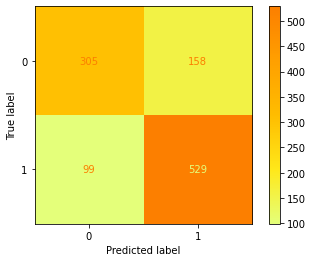

In [12]:
model_metrics(predict_LR, target_test)

### 第二題：Play around with the arguments

#### try to tune model with difference parameters

* model with class_weight = 'balanced'

In [13]:
# parameters of Logistic Regression (class_weight)

model_2 = LogisticRegression(class_weight= 'balanced', random_state = 413)  #initialize the model

model_2.fit(features_train, target_train)  # train the model

predicted_classes_2 = model_2.predict(features_test) # predict
predicted_classes_2


array([1, 1, 0, ..., 0, 0, 1])

In [14]:
# evaluate the performance


predict_LR_2 = model_2.predict(features_test)


print(confusion_matrix(target_test, predict_LR_2))
print(classification_report(target_test, predict_LR_2, target_names=['normal', 'high']))

[[342 121]
 [167 461]]
              precision    recall  f1-score   support

      normal       0.67      0.74      0.70       463
        high       0.79      0.73      0.76       628

    accuracy                           0.74      1091
   macro avg       0.73      0.74      0.73      1091
weighted avg       0.74      0.74      0.74      1091



In [15]:
y_true = target_test
y_pred = model_2.predict(features_test) 

print(f1_score(y_true, y_pred, average='macro'))

0.732843587389042


accuracy: 0.74
precision: 0.73
recall: 0.74
fscore: 0.73


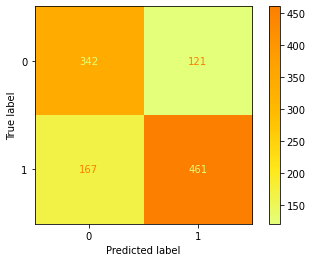

In [16]:
model_metrics(predict_LR_2, target_test)

#### model with C = 1e9

In [17]:
# parameters of Logistic Regression (C)

model_3 = LogisticRegression(C=1e9, random_state = 413)  #initialize the model

model_3.fit(features_train, target_train)  # train the model

predicted_classes_3 = model_3.predict(features_test) # predict
predicted_classes_3



array([1, 1, 0, ..., 0, 0, 1])

In [18]:
# evaluate the performance


predict_LR_3 = model_3.predict(features_test)


print(confusion_matrix(target_test, predict_LR_3))
print(classification_report(target_test, predict_LR_3, target_names=['normal', 'high']))

[[305 158]
 [ 99 529]]
              precision    recall  f1-score   support

      normal       0.75      0.66      0.70       463
        high       0.77      0.84      0.80       628

    accuracy                           0.76      1091
   macro avg       0.76      0.75      0.75      1091
weighted avg       0.76      0.76      0.76      1091



In [19]:
y_true = target_test
y_pred = model_3.predict(features_test) 

print(f1_score(y_true, y_pred, average='macro'))

0.7540691427543954


accuracy: 0.76
precision: 0.76
recall: 0.75
fscore: 0.75


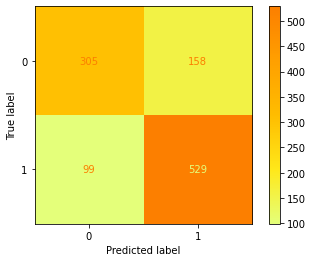

In [20]:
model_metrics(predict_LR_3, target_test)

#### 第二題心得：

* 這題其實我單獨試了好幾個 parameters (單獨測試是因為怕參數之間互相影響)，但許多參數都沒什麼特別大的變化，像是上面有 print 出來的，將 C 調成 1e9，就和沒有調是一樣的，所以就沒有一一列出來了。C 其實應該是個 hyperparameter，讓 model 知道如何選擇 parameter。這裡，較小的 C 值會增強 regularization。但也許因為我的資料算是平均的，所以沒有什麼影響。

* 另外，發現調 class_weighted = 'balanced' 差異滿明顯的，這個參數將每個 class 的權重調成一致。這在沒有那麼不平衡的資料中可以 get 更多 True positive， recall 有機會上升，但也更有可能反而提升 False positive。整體而言，它就是會提高 positive 的量，所以也容易導致最終預測出來的 positive event 高於實際值。而我此次訓練的結果就是這種情況，看 confusion matrics 可以明顯的發現，True positive 提高了，與此同時，False positive 也增加，這樣整體表現反而是呈現下降的結果。還不如不要調

### 第三題：Retrain Logistic Regression with SGDClassifier. Use this approach to re-train a logistic regression model again (and try to tune some parameters), and show the f-score of the model performance. 

* 這邊我使用 class_weight, penalty 和 alpha 來調整模型，loss = 'log_loss' 則代表是 logistic regression 模型。
* alpha 是控制正則化強度的超參數，penalty 則把預設的 l2 改成 l1，但是結果比沒有調過的 logistic regression 還低。我猜是因為 l1 和 l2 本身特質的差異所導致。

* l1 正則化的懲罰項是權重向量中各個元素的絕對值之和，可以將一部分權重歸零，從而使得模型變得更加稀疏，即去掉一些不重要的特徵，使得模型更加簡單，減少過擬合的可能性。因此，l1 正則化常被用於特徵選擇。

* l2 正則化的懲罰項是權重向量中各個元素的平方和，可以使得所有的權重都趨向於接近於 0，但不會歸零。因此，l2 正則化可以減少模型的複雜度，降低過擬合的風險，但不會去掉不重要的特徵。

* 因此，在選擇正則化方法時，需要根據具體的問題和數據特徵來選擇，一般來說，如果特徵數目較多，可以考慮使用 l1 正則化來進行特徵選擇，如果特徵數目較少，可以使用 l2 正則化來降低模型複雜度和減少過擬合的風險。而我的特徵數目不算多，所以可能原本的 l2 比較適合。

In [21]:
#  re-train a logistic regression

model_retrain = SGDClassifier(class_weight = 'balanced', penalty='l1', loss='log_loss', alpha = 0.0005, random_state = 413)

model_retrain.fit(features_train, target_train) 

predicted_classes_re = model_retrain.predict(features_test) # predict
predicted_classes_re

array([1, 1, 0, ..., 0, 0, 0])

In [22]:
# evaluate the performance


predict_LR_re = model_retrain.predict(features_test)


print(confusion_matrix(target_test, predict_LR_re))
print(classification_report(target_test, predict_LR_re, target_names=['normal', 'high']))

[[374  89]
 [214 414]]
              precision    recall  f1-score   support

      normal       0.64      0.81      0.71       463
        high       0.82      0.66      0.73       628

    accuracy                           0.72      1091
   macro avg       0.73      0.73      0.72      1091
weighted avg       0.74      0.72      0.72      1091



In [23]:
y_true = target_test
y_pred = model_retrain.predict(features_test) 

print(f1_score(y_true, y_pred, average='macro'))

0.721899315291487


accuracy: 0.72
precision: 0.73
recall: 0.73
fscore: 0.72


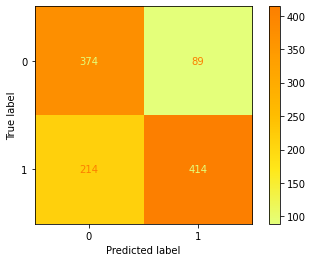

In [24]:
model_metrics(predict_LR_re, target_test)

### 第四題：mini-batches

* 這邊我的 batch size 為 32，進行迭代 10 次，在每個 epoch 中，將數據集分成小批次，使用每個小批次的數據更新模型。最後使用 f-score 評估模型。選用 macro f-score 之原因如前所述。

In [33]:

# Initialize logistic regression model
model_mini = SGDClassifier(penalty='l2', loss='log_loss', alpha = 0.0005, shuffle=True, random_state = 413)

# Set parameters
batch_size = 32
num_epochs = 10

# Train
num_samples = features_train.shape[0]
num_batches = num_samples // batch_size
f_score_ma = []

for i in range(num_epochs):
    for j in range(num_batches):
        X_batch = features_train[j*batch_size:(j+1)*batch_size]
        y_batch = target_train[j*batch_size:(j+1)*batch_size]
        model_mini.partial_fit(X_batch, y_batch, classes=[0, 1])
        
    # Evaluate
    y_pred = model_mini.predict(features_test)
    score = f1_score(target_test, y_pred, average='macro')
    f_score_ma.append(score)


* 10 次 f-score 成績

In [34]:
f_score_ma

[0.7211184256600602,
 0.7156135323583546,
 0.7270757930593996,
 0.7311855213244939,
 0.7322704130222355,
 0.7322704130222355,
 0.732965926994116,
 0.7318870046109021,
 0.7348939708425339,
 0.7381199477567157]

* 10 次 f-score 的平均

In [35]:
mean(f_score_ma)

0.7297400948651047

* 這裡發現做越多次平均下來的分數較前面又低了一些，但我想，這樣的結果應該是表示模型呈現較穩定的狀態，也不會太過擬合。

### 第五題：Plot out f-scores of the models trained with different learning rates

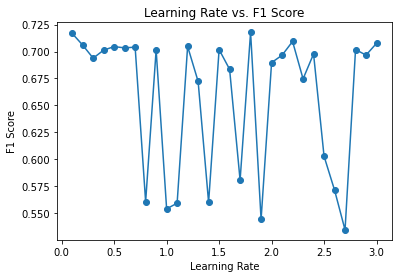

In [32]:

# set 0.1 to 3.0 learning rate
learning_rates = np.linspace(0.1, 3.0, num=30)

# train the model and calculate f-score (macro)

f1_scores = []
for lr in learning_rates:
    lr_model = SGDClassifier(penalty='l2', loss = 'log_loss', max_iter=1000, learning_rate='constant', eta0=lr, random_state = 413)
    lr_model.fit(features_train, target_train)
    y_pred = lr_model.predict(features_test)
    score = f1_score(target_test, y_pred, average='macro')
    f1_scores.append(score)

# plot f-score

plt.plot(learning_rates, f1_scores, 'o-')
plt.xlabel('Learning Rate')
plt.ylabel('F1 Score')
plt.title('Learning Rate vs. F1 Score')
plt.show()


* learning rate 約在 0.6 之前 f-score 較為穩定，之後不斷起伏，在 1.7 左右達到最高峰，隨後快速下降，繼續起起伏伏。因此，從這次實驗與這張圖所表現，我偏向將 learning rate 控制在 1 以前，畢竟在 1 以前可能不會有突然的高峰，但成績都不低，也較為穩定。